# Daily Forecast Example

Daily forecast is one of most popular use cases in time-series modeling. In this example, it aims to introduce a way to perform a daily forecast by modeling yearly and weekly seasonality together. We will use the aggregated number of sales from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).

In [212]:
import pandas as pd
import numpy as np
from orbit.models.dlt import DLTMAP
from orbit.diagnostics.plot import plot_predicted_data

For demo purpose, we just use a subset of regressors and perform log transformation on response to construct a multiplicative model.

In [216]:
df = pd.read_csv('./data/m5_agg_demand.csv', parse_dates=['date'])
# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]
df = df[["date", "sales"] + regressor_col]
df['sales_log1p'] = np.log1p(df['sales'])
df.head(5)

,date,sales,Christmas,Halloween,LaborDay,Thanksgiving,Mother's day,PresidentsDay,NewYear,sales_log1p
0,2011-01-29,32631,0,0,0,0,0,0,0,10.393049
1,2011-01-30,31749,0,0,0,0,0,0,0,10.365648
2,2011-01-31,23783,0,0,0,0,0,0,0,10.076768
3,2011-02-01,25412,0,0,0,0,0,0,0,10.143016
4,2011-02-02,19146,0,0,0,0,0,0,0,9.859901


In [217]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

Note that `level_sm_input` are used to fix level smoothing parameter. This is recommended in daily or higher frequency data.

In [219]:
dlt = DLTMAP(
    response_col='sales_log1p',
    date_col='date',
    seasonality=7,
    seed=2020,
    is_multiplicative=False,
    regressor_col=regressor_col,
    level_sm_input=0.3, # recommend for higher frequency data
    regressor_sigma_prior=[0.5] * len(regressor_col),
    regression_penalty='lasso',
    period=365,
)

In [220]:
dlt.fit(train_df)

In [223]:
predicted_df = dlt.predict(df=df)
predicted_df['prediction'] = np.expm1(predicted_df['prediction'])
predicted_df.head(5)

,date,prediction
0,2011-01-29,32631.000000
1,2011-01-30,32560.290395
2,2011-01-31,25212.002547
3,2011-02-01,23065.132805
4,2011-02-02,23332.539868


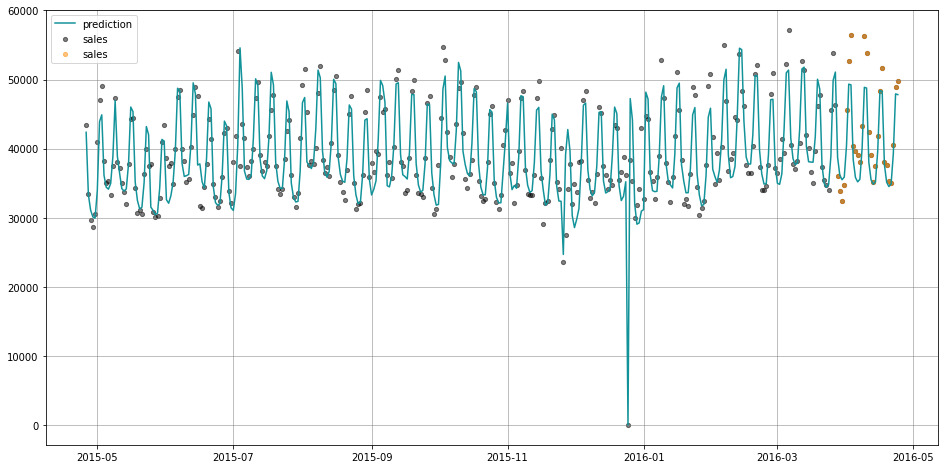

In [227]:
plot_predicted_data(training_actual_df=df[-365:], predicted_df=predicted_df[-365:], 
                    test_actual_df=test_df, date_col=dlt.date_col,
                    actual_col='sales', pred_col='prediction')